In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score

In [2]:
with open('trainoldYoungALLDEment.txt', 'r', encoding='utf-8-sig') as fin:
    with open('train.txt', 'w', encoding='utf-8-sig') as fout:
        for line in fin.readlines():
            fout.write(line.replace(',', '.'))

In [3]:
data = pd.read_csv('train.txt', sep='\t')

features = data.columns.values[2:]
target = np.array(list(set(data['cl'])))

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://bstudy.net/htm/img/3/10226/19.png", width=500, height=500)

In [5]:
print('features:', len(features))
print(features)

features: 256
['channel=Fp1_1' 'channel=Fp1_2' 'channel=Fp1_3' 'channel=Fp1_4'
 'channel=Fp1_5' 'channel=Fp1_6' 'channel=Fp1_7' 'channel=Fp1_8'
 'channel=Fp1_9' 'channel=Fp1_10' 'channel=Fp1_11' 'channel=Fp1_12'
 'channel=Fp1_13' 'channel=Fp1_14' 'channel=Fp1_15' 'channel=Fp1_16'
 'channel=Fp2_1' 'channel=Fp2_2' 'channel=Fp2_3' 'channel=Fp2_4'
 'channel=Fp2_5' 'channel=Fp2_6' 'channel=Fp2_7' 'channel=Fp2_8'
 'channel=Fp2_9' 'channel=Fp2_10' 'channel=Fp2_11' 'channel=Fp2_12'
 'channel=Fp2_13' 'channel=Fp2_14' 'channel=Fp2_15' 'channel=Fp2_16'
 'channel=F33_1' 'channel=F33_2' 'channel=F33_3' 'channel=F33_4'
 'channel=F33_5' 'channel=F33_6' 'channel=F33_7' 'channel=F33_8'
 'channel=F33_9' 'channel=F33_10' 'channel=F33_11' 'channel=F33_12'
 'channel=F33_13' 'channel=F33_14' 'channel=F33_15' 'channel=F33_16'
 'channel=F4_1' 'channel=F4_2' 'channel=F4_3' 'channel=F4_4'
 'channel=F4_5' 'channel=F4_6' 'channel=F4_7' 'channel=F4_8'
 'channel=F4_9' 'channel=F4_10' 'channel=F4_11' 'channel=F4_12'

In [6]:
print('target:', *target)

target: 1 2


In [7]:
print('1:', np.sum(data['cl'] == 1))
print('2:', np.sum(data['cl'] == 2))

1: 50
2: 34


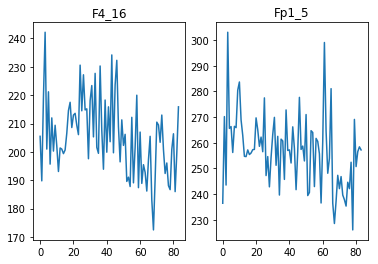

In [8]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(data['channel=F4_16'])
axs[0].set_title('F4_16')

axs[1].plot(data['channel=Fp1_5'])
axs[1].set_title('Fp1_5')

plt.show()

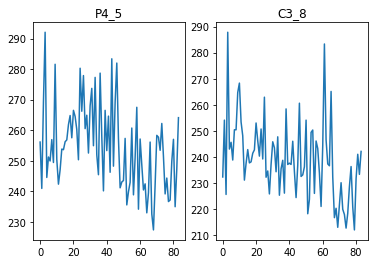

In [9]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(data['channel=P4_5'])
axs[0].set_title('P4_5')

axs[1].plot(data['channel=C3_8'])
axs[1].set_title('C3_8')

plt.show()

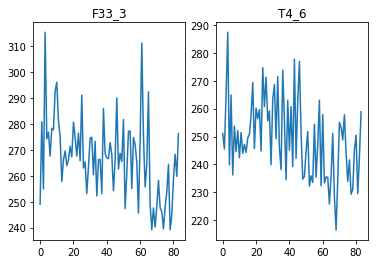

In [10]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(data['channel=F33_3'])
axs[0].set_title('F33_3')

axs[1].plot(data['channel=T4_6'])
axs[1].set_title('T4_6')

plt.show()

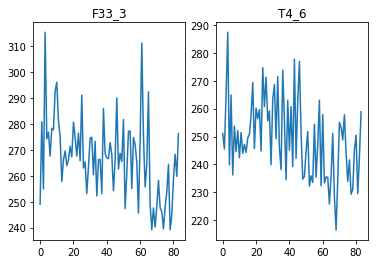

In [11]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(data['channel=F33_3'])
axs[0].set_title('F33_3')

axs[1].plot(data['channel=T4_6'])
axs[1].set_title('T4_6')

plt.show()

In [12]:
x_data = data.values[:, 2:].astype(np.float32)
y_data = data.values[:, 1].astype(np.int64) - 1

size = x_data.shape[1]
size

256

В силу отсутсвия большого количества прецедентов буду обучать модель при помощи StratifiedKFold.

Оптимизация: Adadelta.

In [13]:
def train(network, epochs, learning_rate, n_sp, opt='adadelta'):
    loss = nn.NLLLoss()
    skf = StratifiedKFold(n_splits=n_sp, shuffle=True)
    if opt == 'adam':
        optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    elif opt == 'adadelta':
        optimizer = torch.optim.Adadelta(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs + 1):
            losses = []
            accuracies = []
            for train_index, test_index in skf.split(x_data, y_data):
                X_train, X_test = x_data[train_index], x_data[test_index]
                y_train, y_test = y_data[train_index], y_data[test_index]

                train_loader = DataLoader([(X_train[i], y_train[i])
                                         for i in range(y_train.shape[0])],
                                        batch_size=10, shuffle=True)
                test_loader = DataLoader([(X_test[i], y_test[i])
                                        for i in range(y_test.shape[0])],
                                       batch_size=10, shuffle=False)

                for X, y in train_loader:
                    network.zero_grad()
                    prediction = network(X)
                    loss_batch = loss(prediction, y)
                    losses.append(loss_batch.item())
                    loss_batch.backward()
                    optimizer.step()
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())

                train_loss_epochs.append(np.mean(losses))
                train_accuracy_epochs.append(np.mean(accuracies))
                losses = []
                accuracies = []
                
                for X, y in test_loader:
                    prediction = network(X)
                    loss_batch = loss(prediction, y)
                    losses.append(loss_batch.item())
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                test_loss_epochs.append(np.mean(losses))
                test_accuracy_epochs.append(np.mean(accuracies))
                
            if epoch % 50 == 0:
                clear_output(True)
                print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
                plt.figure(figsize=(12, 5))
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass

In [14]:
class LinClassifier(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(size, size // 2),
                                    nn.ReLU(),
                                    nn.Linear(size // 2, size // 4),
                                    nn.ReLU(),
                                    nn.Linear(size // 4, size // 8),
                                    nn.ReLU(),
                                    nn.Linear(size // 8, size // 16),
                                    nn.ReLU(),
                                    nn.Linear(size // 16, len(target)),
                                    nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

Обучим модель:

Epoch 300... (Train/Test) NLL: 0.616/0.556	Accuracy: 0.674/0.783


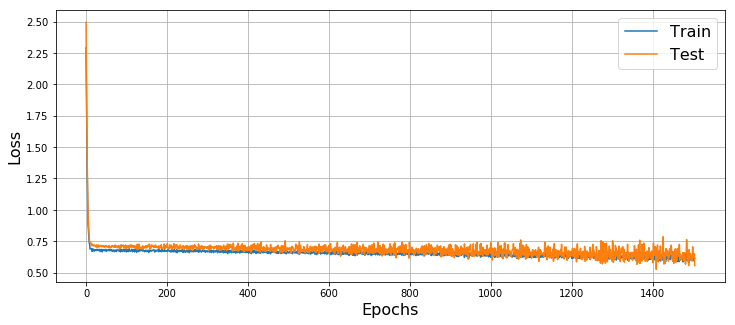

In [15]:
network = LinClassifier(size)
train(network, 300, 0.006, 5, 'adadelta')

Оценка ROC AUC:

In [16]:
roc_auc_score(np.argmax(network.forward(torch.Tensor(x_data)).data.numpy(), 1),
              y_data)

0.8290441176470589

Попробуем предобработать данные, центрировав их.

In [17]:
x_data -= np.mean(x_data, 1).reshape(-1, 1)

Оптимизатор: Adam.

Epoch 200... (Train/Test) NLL: 0.057/0.064	Accuracy: 0.961/1.000


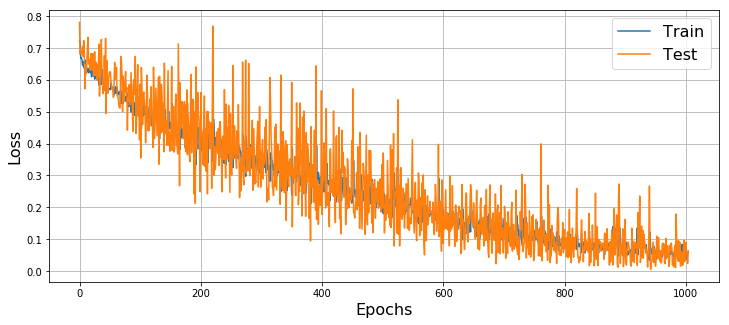

In [18]:
network = LinClassifier(size)
train(network, 200, 0.00005, 5, 'adam')

Оценка ROC AUC:

In [19]:
roc_auc_score(np.argmax(network.forward(torch.Tensor(x_data)).data.numpy(), 1),
              y_data)

0.9807692307692308